<a href="https://colab.research.google.com/github/kmeng01/rome/blob/main/notebooks/causal_trace.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" align="left"/></a>&nbsp;or in a local notebook.

In [105]:
%%bash
!(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit
cd /content && rm -rf /content/rome
git clone https://github.com/kmeng01/rome rome > install.log 2>&1
pip install -r /content/rome/scripts/colab_reqs/rome.txt >> install.log 2>&1
pip install --upgrade google-cloud-storage >> install.log 2>&1

In [1]:
IS_COLAB = False
try:
    import google.colab, torch, os

    IS_COLAB = True
    os.chdir("/content/rome")
    if not torch.cuda.is_available():
        raise Exception("Change runtime type to include a GPU.")
except ModuleNotFoundError as _:
    pass

## Causal Tracing

A demonstration of the double-intervention causal tracing method.

The strategy used by causal tracing is to understand important
states within a transfomer by doing two interventions simultaneously:

1. Corrupt a subset of the input.  In our paper, we corrupt the subject tokens
   to frustrate the ability of the transformer to accurately complete factual
   prompts about the subject.
2. Restore a subset of the internal hidden states.  In our paper, we scan
   hidden states at all layers and all tokens, searching for individual states
   that carry the necessary information for the transformer to recover its
   capability to complete the factual prompt.

The traces of decisive states can be shown on a heatmap.  This notebook
demonstrates the code for conducting causal traces and creating these heatmaps.

In [107]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The `experiments.causal_trace` module contains a set of functions for running causal traces.

In this notebook, we reproduce, demonstrate and discuss the interesting functions.

We begin by importing several utility functions that deal with tokens and transformer models.

In [2]:
import os, re, json
import torch, numpy
from collections import defaultdict
from util import nethook
from util.globals import DATA_DIR
from experiments.causal_trace import (
    ModelAndTokenizer,
    layername,
    guess_subject,
    plot_trace_heatmap,
)
from experiments.causal_trace import (
    make_inputs,
    decode_tokens,
    find_token_range,
    predict_token,
    predict_from_input,
    collect_embedding_std,
)
from dsets import KnownsDataset

os.environ["CUDA_VISIBLE_DEVICES"] = "3"

torch.set_grad_enabled(False)

/ais/clspace5/niu/envs/andrew/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [109]:
torch.cuda.empty_cache()

Now we load a model and tokenizer, and show that it can complete a couple factual statements correctly.

In [3]:
model_name = "bert-large-cased"  # or "EleutherAI/gpt-j-6B" or "EleutherAI/gpt-neox-20b"
mt = ModelAndTokenizer(
    model_name,
    low_cpu_mem_usage=IS_COLAB,
    torch_dtype=(torch.float16 if "20b" in model_name else None),
)

Some weights of the model checkpoint at bert-large-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
predict_token(
    mt,
    ["I want to [MASK] to the mall.", "He [MASK] me to go to the dance.", "I can't wait to [MASK] to go to bathroom."],
    return_p=True,
)

/h/120/andrewliu/Modified-Rome/notebooks/experiments/causal_trace.py:711: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return preds, torch.tensor(probs)


(['go', 'wants', 'get'], tensor([0.9694, 0.4487, 0.3463]))

In [5]:
knowns = KnownsDataset(DATA_DIR)  # Dataset of known facts

Loaded dataset with 1209 elements


To obfuscate the subject during Causal Tracing, we use noise sampled from a zero-centered spherical Gaussian, whose stddev is 3 times the $\sigma$ stddev the model's embeddings. Let's compute that value.

In [6]:
#knowns = KnownsDataset(DATA_DIR)  # Dataset of known facts
noise_level = 3 * collect_embedding_std(mt, [k["subject"] for k in knowns])
print(f"Using noise level {noise_level}")

Using noise level 0.1725940704345703


## Tracing a single location

The core intervention in causal tracing is captured in this function:

`trace_with_patch` a single causal trace.

It enables running a batch of inferences with two interventions.

  1. Random noise can be added to corrupt the inputs of some of the batch.
  2. At any point, clean non-noised state can be copied over from an
     uncorrupted batch member to other batch members.
  
The convention used by this function is that the zeroth element of the
batch is the uncorrupted run, and the subsequent elements of the batch
are the corrupted runs.  The argument tokens_to_mix specifies an
be corrupted by adding Gaussian noise to the embedding for the batch
inputs other than the first element in the batch.  Alternately,
subsequent runs could be corrupted by simply providing different
input tokens via the passed input batch.

To ensure that corrupted behavior is representative, in practice, we
will actually run several (ten) corrupted runs in the same batch,
each with its own sample of noise.

Then when running, a specified set of hidden states will be uncorrupted
by restoring their values to the same vector that they had in the
zeroth uncorrupted run.  This set of hidden states is listed in
states_to_patch, by listing [(token_index, layername), ...] pairs.
To trace the effect of just a single state, this can be just a single
token/layer pair.  To trace the effect of restoring a set of states,
any number of token indices and layers can be listed.

Note that this function is also in experiments.causal_trace; the code
is shown here to show the logic.

In [7]:
#pass in the model, the input containing 10 copies of both the tokens and the attention, pass in the range for the subject tokens, pass in the answer, pass in noise

def trace_with_patch(
    model,  # The model
    inp,  # A set of inputs
    states_to_patch,  # A list of (token index, layername) triples to restore
    answers_t,  # Answer probabilities to collect
    tokens_to_mix,  # Range of tokens to corrupt (begin, end)
    noise=0.1,  # Level of noise to add
    trace_layers=None,  # List of traced outputs to return
):
    prng = numpy.random.RandomState(1)  # For reproducibility, use pseudorandom noise
    patch_spec = defaultdict(list)

    #we need to add the calculation of the mask location from inp
    mask_position =  torch.where(inp["input_ids"][1] == mt.tokenizer.mask_token_id)[0][0]

    for t, l in states_to_patch:
        if t == mask_position:
            continue
        patch_spec[l].append(t)
    embed_layername = layername(model, 0, "embed")

    def untuple(x):
        return x[0] if isinstance(x, tuple) else x

    # Define the model-patching rule.
    def patch_rep(x, layer):
        if layer == embed_layername:
            # If requested, we corrupt a range of token embeddings on batch items x[1:]
            if tokens_to_mix is not None:
                b, e = tokens_to_mix
                x[1:, b:e] += noise * torch.from_numpy(
                    prng.randn(x.shape[0] - 1, e - b, x.shape[2])
                ).to(x.device)
            return x
        if layer not in patch_spec:
            return x
        # If this layer is in the patch_spec, restore the uncorrupted hidden state
        # for selected tokens.
        h = untuple(x)
        for t in patch_spec[layer]:
            h[1:, t] = h[0, t]
        return x
    


    # With the patching rules defined, run the patched model in inference.
    additional_layers = [] if trace_layers is None else trace_layers

    with torch.no_grad(), nethook.TraceDict(
        model,
        [embed_layername] + list(patch_spec.keys()) + additional_layers,
        edit_output=patch_rep,
    ) as td:
        outputs_exp = model(**inp)

        

    # We report softmax probabilities for the answers_t token predictions of interest.
    probs = torch.softmax(outputs_exp.logits[1:, mask_position, :], dim=1).mean(dim=0)[answers_t]


    # If tracing all layers, collect all activations together to return.
    if trace_layers is not None:
        all_traced = torch.stack(
            [untuple(td[layer].output).detach().cpu() for layer in trace_layers], dim=2
        )
        return probs, all_traced

    return probs

## Scanning all locations

A causal flow heatmap is created by repeating `trace_with_patch` at every individual hidden state, and measuring the impact of restoring state at each location.

The `calculate_hidden_flow` function does this loop.  It handles both the case of restoring a single hidden state, and also restoring MLP or attention states.  Because MLP and attention make small residual contributions, to observe a causal effect in those cases, we need to restore several layers of contributions at once, which is done by `trace_important_window`.

In [8]:
def calculate_hidden_flow(
    mt, prompt, target, anti_target, focused, subject, samples=10, noise=0.1, window=10, kind=None
):
    """
    Runs causal tracing over every token/layer combination in the network
    and returns a dictionary numerically summarizing the results.
    """
    inp = make_inputs(mt.tokenizer, [prompt] * (samples + 1))
    #create 11 copies of tokens from our prompt sentence


    answer = target

    answer_t = mt.tokenizer.convert_tokens_to_ids(target)

    anti_answer = anti_target

    if not (anti_answer == None):
        anti_answer_t = mt.tokenizer.convert_tokens_to_ids(anti_target)

    #answer is what the model fills the blank in with

    #pass in a tokenizer, the tokenized ids, and the subject

    e_range = find_token_range(mt.tokenizer, inp["input_ids"][0], subject)

    #e_range contains [subject token start index, subject token end index], we will obfuscate/corrupt the tokens in this range


    #pass in the model, the input containing 10 copies of both the tokens and the attention, pass in the range for the subject tokens, pass in the answer, pass in noise
    low_score = trace_with_patch(
        mt.model, inp, [], answer_t, e_range, noise=noise
    ).item()


    if (anti_answer != None):
        low_score = low_score - trace_with_patch(
            mt.model, inp, [], anti_answer_t, e_range, noise=noise
        ).item()

    
    if not kind:
        differences = trace_important_states(
            mt.model, mt.num_layers, inp, e_range, answer_t, noise=noise
        )

        if (anti_answer != None):
            differences = differences - trace_important_states(
                mt.model, mt.num_layers, inp, e_range, anti_answer_t, noise=noise
            )
    else:
        differences = trace_important_window(
            mt.model,
            mt.num_layers,
            inp,
            e_range,
            answer_t,
            noise=noise,
            window=window,
            kind=kind,
        )

        if (anti_answer != None):
            differences = differences - trace_important_window(
                mt.model,
                mt.num_layers,
                inp,
                e_range,
                anti_answer_t,
                noise=noise,
                window=window,
                kind=kind,
            )
            
    differences = differences.detach().cpu()
    
    
        

    dict = {}

    
    dict["scores"] = differences - low_score
    dict["low_score"] = 0
    
    '''dict["scores"] = differences
    dict["low_score"] = low_score'''
    dict["input_ids"] = inp["input_ids"][0]
    dict["input_tokens"] = decode_tokens(mt.tokenizer, inp["input_ids"][0])
    dict["subject_range"]=e_range
    dict["answer"] = answer
    dict["window"] = window
    dict["kind"] = kind or ""

  
  

    if focused == True:
        focused_index = e_range[1] - 1
        dict["scores"] = dict["scores"][focused_index:focused_index+1]
        dict["input_ids"] = dict["input_ids"][focused_index:focused_index+1]
        dict["input_tokens"] = dict["input_tokens"][focused_index:focused_index+1]
        dict["subject_range"]=(0,0)

    return dict

def trace_important_states(model, num_layers, inp, e_range, answer_t, noise=0.1):
    ntoks = inp["input_ids"].shape[1]
    table = []
    for tnum in range(ntoks):
        row = []
        for layer in range(0, num_layers):
            r = trace_with_patch(
                model,
                inp,
                [(tnum, layername(model, layer))],
                answer_t,
                tokens_to_mix=e_range,
                noise=noise,
            )
            row.append(r)
        table.append(torch.stack(row))
    return torch.stack(table)


def trace_important_window(
    model, num_layers, inp, e_range, answer_t, kind, window=10, noise=0.1
):
    ntoks = inp["input_ids"].shape[1]
    table = []
    for tnum in range(ntoks):
        row = []
        for layer in range(0, num_layers):
            layerlist = [
                (tnum, layername(model, L, kind))
                for L in range(
                    max(0, layer - window // 2), min(num_layers, layer - (-window // 2))
                                #  5                                     - 5
                )
            ]
            r = trace_with_patch(
                model, inp, layerlist, answer_t, tokens_to_mix=e_range, noise=noise
            )
            row.append(r)
        table.append(torch.stack(row))
    return torch.stack(table)

## Plotting the results

The `plot_trace_heatmap` function draws the data on a heatmap.  That function is not shown here; it is in `experiments.causal_trace`.


In [9]:
def plot_hidden_flow(
    mt,
    prompt,
    target,
    anti_target,
    focused,
    subject=None,
    samples=10,
    noise=0.1,
    window=10,
    kind=None,
    modelname=None,
    savepdf=None,
):
    if subject is None:
        subject = guess_subject(prompt)
    result = calculate_hidden_flow(
        mt, prompt, target, anti_target, focused, subject, samples=samples, noise=noise, window=window, kind=kind
    )

    plot_trace_heatmap(result, focused, savepdf, modelname=modelname)


def plot_all_flow(mt, prompt, target, subject=None, noise=0.1, modelname=None, anti_target = None, focused = False):
    values_dict = {}
    for kind in [None, "mlp", "attn"]:
        values = plot_hidden_flow(
            mt, prompt, target, anti_target, focused, subject, modelname=modelname, noise=noise, kind=kind
        )

        values_dict[kind] = values
    return values_dict

The following prompt can be changed to any factual statement to trace.

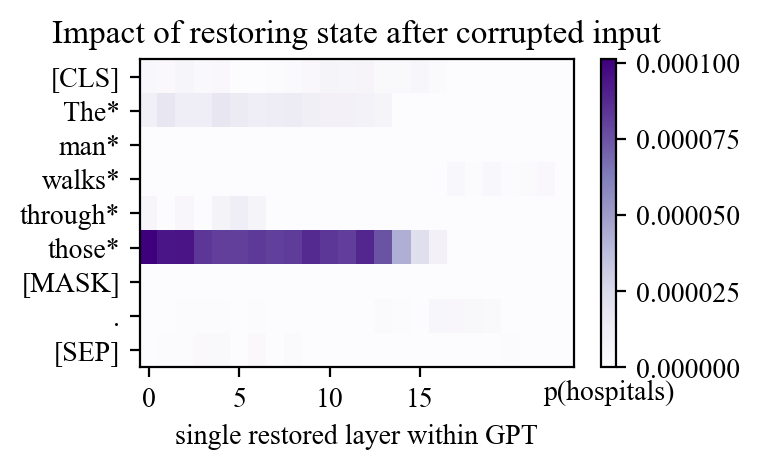

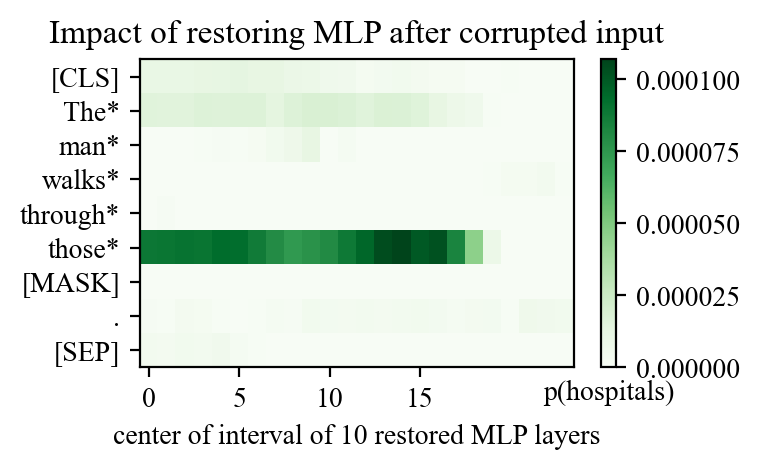

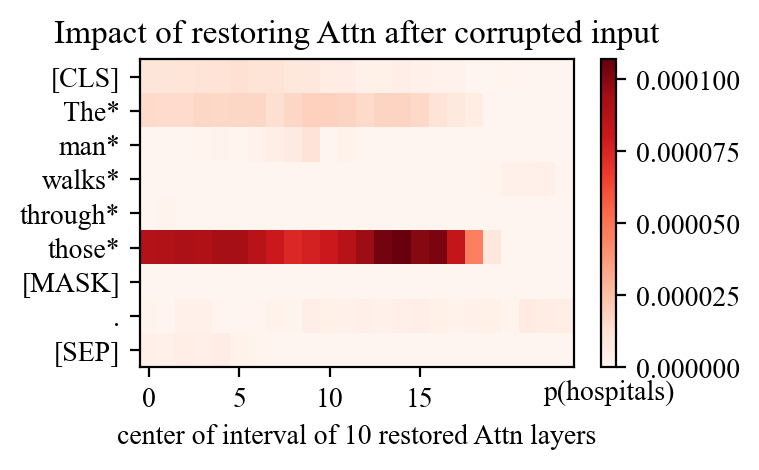

{None: None, 'mlp': None, 'attn': None}

In [117]:
plot_all_flow(mt, "The man walks through those [MASK].", target = "hospitals", anti_target = "hospital", subject="The man walks through those", noise=noise_level)

## Here we plot only the distribution on the masked token

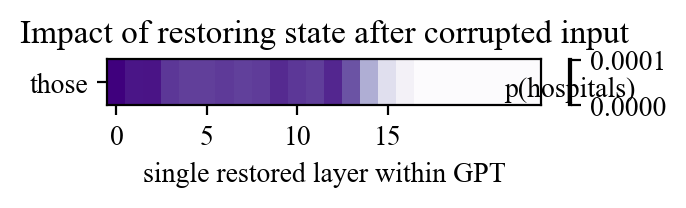

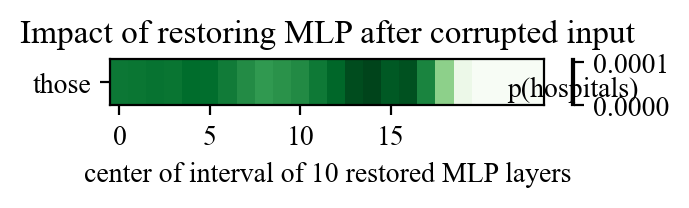

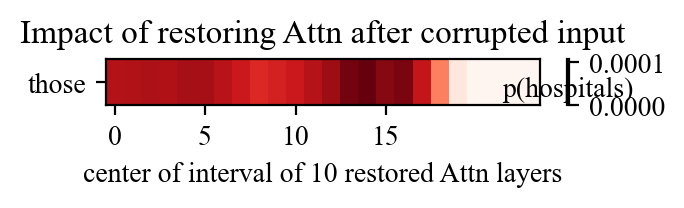

{None: None, 'mlp': None, 'attn': None}

In [118]:
plot_all_flow(mt, "The man walks through those [MASK].", target = "hospitals", anti_target = "hospital", subject="The man walks through those", noise=noise_level, focused = True)

Here we plot an aggregation of a grammar pattern

In [10]:
import json

grammar_rule = "determiner_noun_agreement_1"

with open('./data/' + grammar_rule + '.jsonl', 'r') as json_file:
    json_list = list(json_file)

sentences_list = []


if grammar_rule == "determiner_noun_agreement_1" or grammar_rule == "determiner_noun_agreement_irregular_1":
    for instance in json_list:
        sentence = json.loads(instance)
        if len(sentence['one_prefix_word_good'].split()) == 1:
            dict ={}
            dict["masked_sentence"] = sentence['one_prefix_prefix'] + " [MASK]."
            dict["good_word"] = sentence['one_prefix_word_good']
            dict["bad_word"] = sentence['one_prefix_word_bad']

            dict["subject"] = sentence['one_prefix_prefix']
            sentences_list.append(dict)

if grammar_rule == "regular_plural_subject_verb_agreement_1" or grammar_rule == "principle_A_case_1":

    for instance in json_list:
        sentence = json.loads(instance)
        if len(sentence['one_prefix_word_good'].split()) == 1:
            dict = {}
            dict["good_word"] = sentence["one_prefix_word_good"]
            dict["bad_word"] = sentence["one_prefix_word_bad"]
            dict["subject"] = sentence["one_prefix_prefix"]

            suffix = ' '.join(sentence['sentence_good'].split()[sentence['sentence_good'].split().index(sentence['one_prefix_word_good'])+1:])
            dict["masked_sentence"] = sentence["one_prefix_prefix"] + " [MASK] " + suffix
            sentences_list.append(dict)



In [120]:
total_mlp_scores = torch.zeros(1, 24)


total_low_scores = 0


list_of_grammar_scores = []


length = 0

for sentence in sentences_list[0:500]:
    mlp_scores = calculate_hidden_flow(mt, prompt=sentence["masked_sentence"], target = sentence["good_word"], anti_target = sentence["bad_word"], focused = True, subject=sentence["subject"], samples=10, noise=noise_level, window = 5, kind="mlp")
    total_mlp_scores += mlp_scores["scores"]

    total_low_scores += mlp_scores["low_score"]

    list_of_grammar_scores.append([mlp_scores["scores"], grammar_rule])

    length += 1


total_mlp_scores = total_mlp_scores / length


total_low_scores = total_low_scores / length

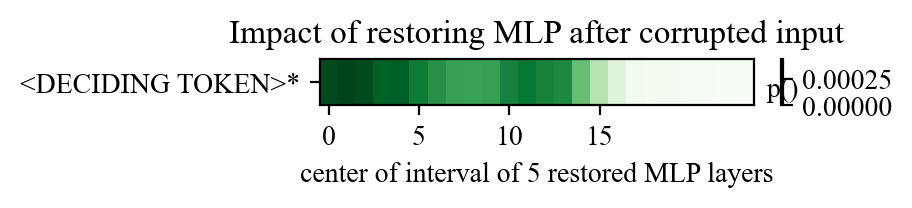

In [121]:
to_plot = {}
to_plot["scores"] = total_mlp_scores


to_plot["kind"] = "mlp"
to_plot["low_score"] = total_low_scores

to_plot["input_ids"] = ["<DECIDING TOKEN>"]
to_plot["input_tokens"] = ["<DECIDING TOKEN>"]

to_plot["subject_range"] = [0, 1]
to_plot["answer"] = ""

to_plot["window"] = 5

plot_trace_heatmap(to_plot, True, None, None)

Here we plot an aggregation of the KNOWNS dataset

In [122]:
total_mlp_scores_facts = torch.zeros(1, 24)


total_low_scores_facts = 0


length_facts = 0

list_of_scores = []



for relation in knowns[:500]:
    mlp_scores = calculate_hidden_flow(mt, prompt = relation["prompt"] + " [MASK].", target = relation["attribute"], anti_target = None, focused = True, subject=relation["subject"], samples=10, noise=noise_level, window = 5, kind="mlp")
    total_mlp_scores_facts += mlp_scores["scores"]
    total_low_scores_facts += mlp_scores["low_score"]

    list_of_scores.append([mlp_scores["scores"], relation["prompt"] + " " + relation["attribute"] + "."])

    length_facts += 1

total_mlp_scores_facts = total_mlp_scores_facts / length_facts
total_low_scores_facts = total_low_scores_facts / length_facts
        

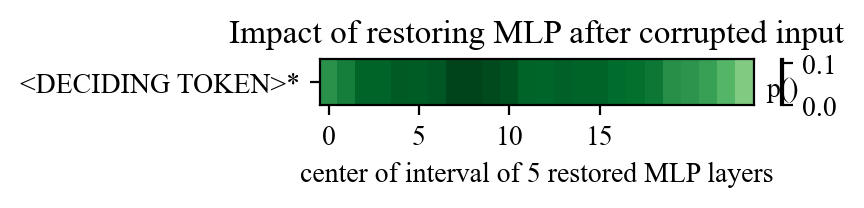

In [123]:
to_plot = {}
to_plot["scores"] = total_mlp_scores_facts


to_plot["kind"] = "mlp"
to_plot["low_score"] = total_low_scores_facts

to_plot["input_ids"] = ["<DECIDING TOKEN>"]
to_plot["input_tokens"] = ["<DECIDING TOKEN>"]

to_plot["subject_range"] = [0, 1]
to_plot["answer"] = ""

to_plot["window"] = 5

plot_trace_heatmap(to_plot, True, None, None)

Plot the individual graphs

In [12]:
import matplotlib.pyplot as plt

def plot_individual(scores, kind = None):
    
    #create a line graph



    x_labels = [i for i in range(24)]

    plt.scatter(x_labels, scores[0][0], s = 10)
    plt.plot(x_labels, scores[0][0])
    plt.xlabel("Layer")
    plt.ylabel("Average Indirect Effect")

    if kind == "facts":
        plt.title("Fact: " + scores[1])
    if kind == "grammar":
        plt.title("Grammar Pattern: " + scores[1])

    plt.show()

def plot_together(list_of_scores, kind = None):

    
    #create a line graph
    counter = 0
    for scores in list_of_scores:
        if kind == "facts" and torch.max(scores[0][0]) < 0.5:
            continue
        if kind == "grammar" and torch.max(scores[0][0]) < 0.002:
            continue
        x_labels = [i for i in range(24)]

        counter += 1

        plt.scatter(x_labels, scores[0][0], s = 10)
        plt.plot(x_labels, scores[0][0])
        plt.xlabel("Layer")
        plt.ylabel("Average Indirect Effect")
        if kind == "facts":
            plt.title("All facts")
        if kind == "grammar":
            plt.title("Grammar Pattern: " + scores[1])
    
    plt.show()
    print(counter)
        



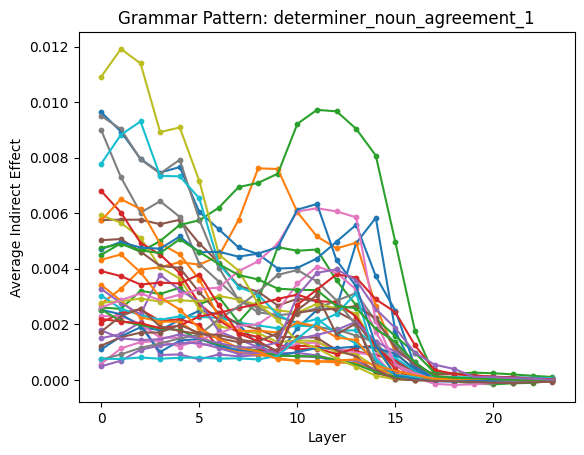

36


In [13]:
grammar_file = torch.load('./data/determiner_noun_agreement_results.pt')

plot_together(grammar_file, kind = "grammar")

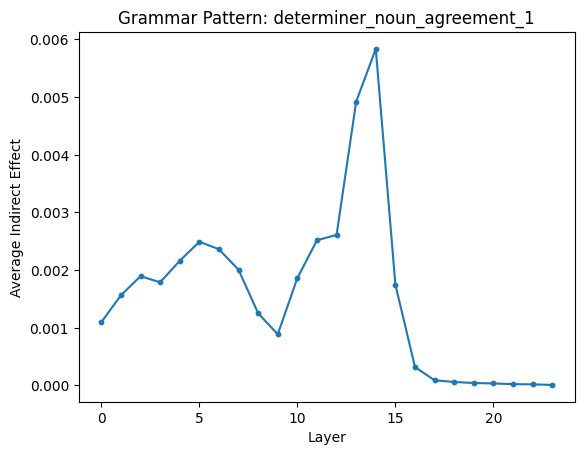

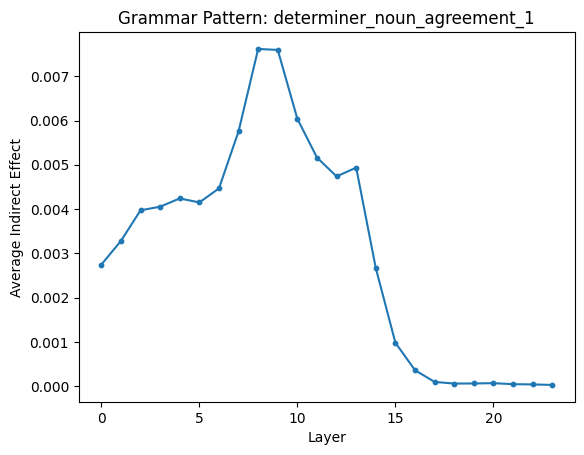

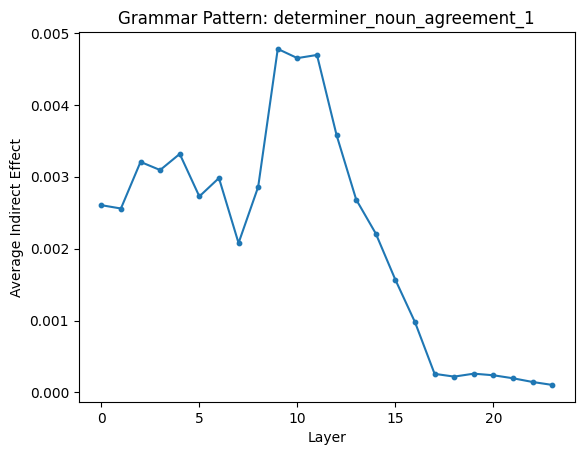

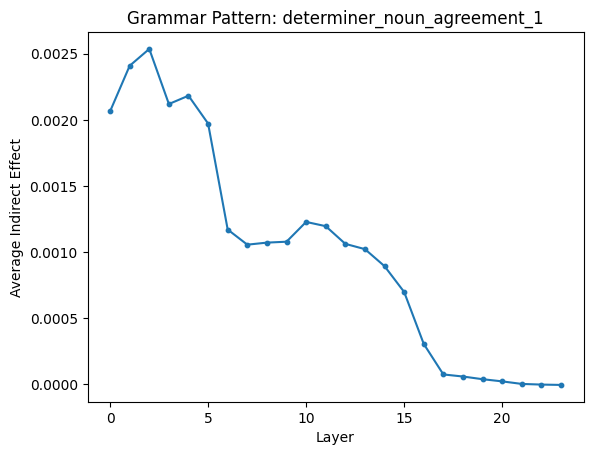

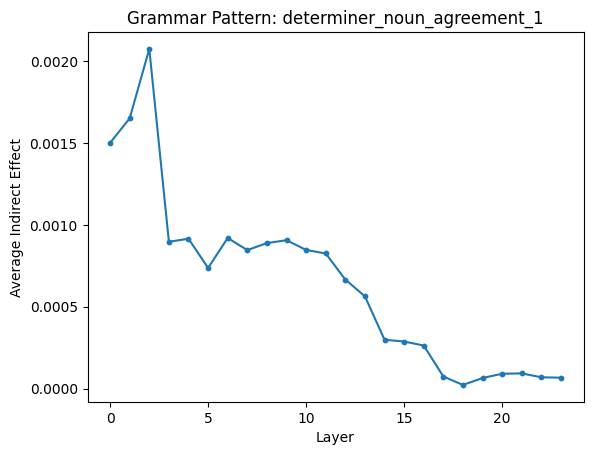

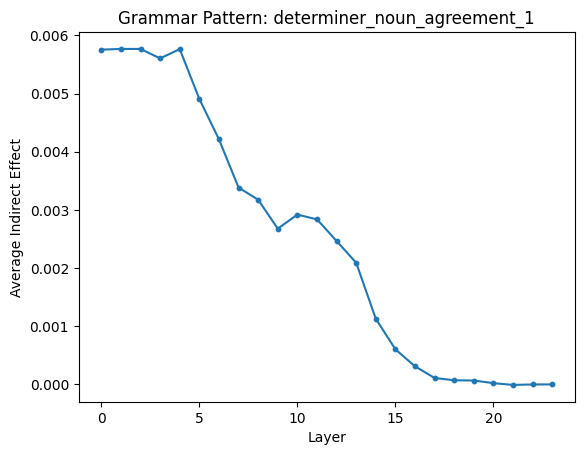

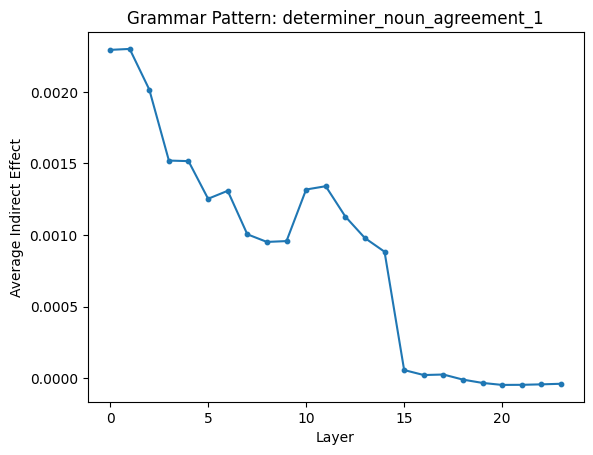

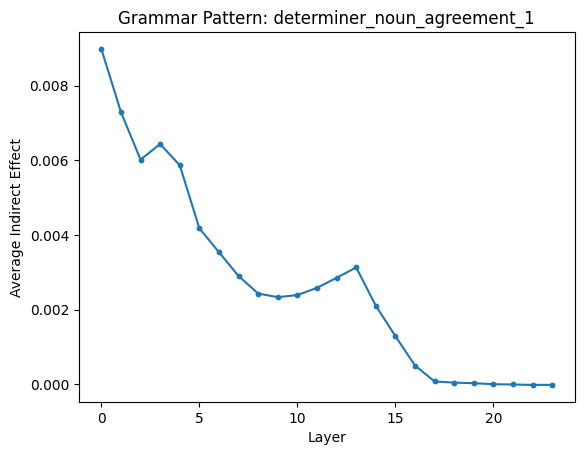

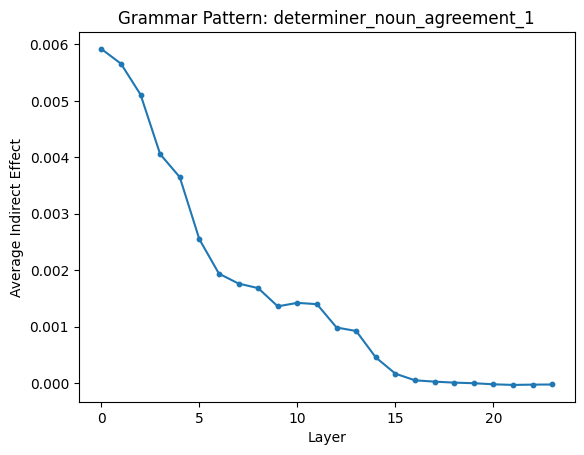

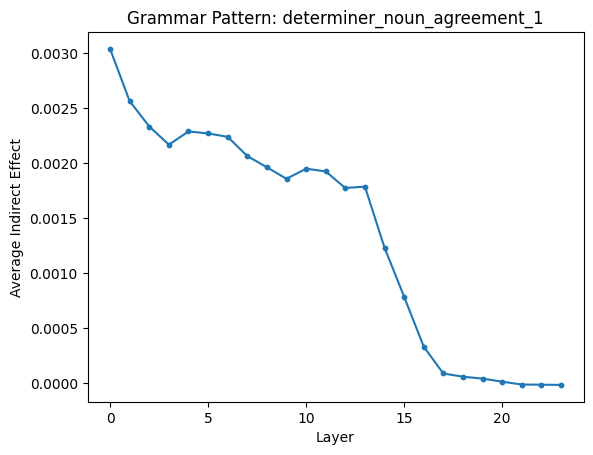

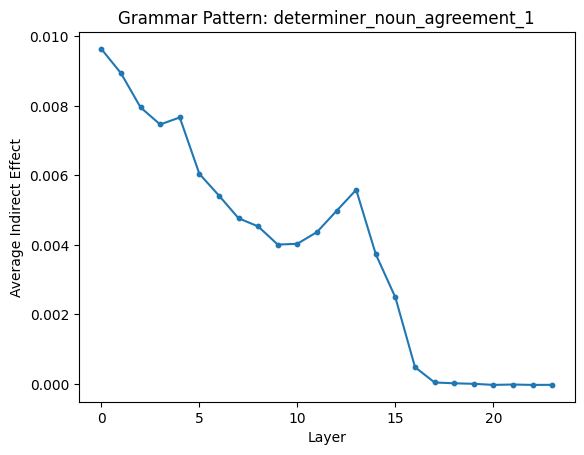

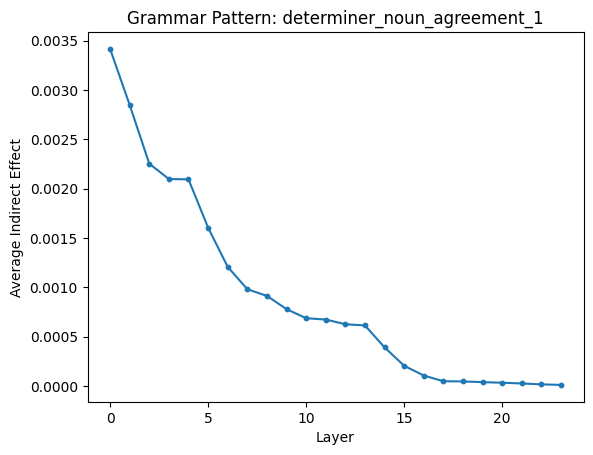

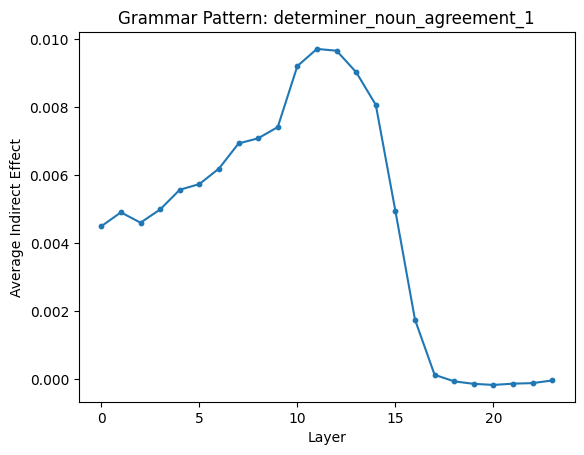

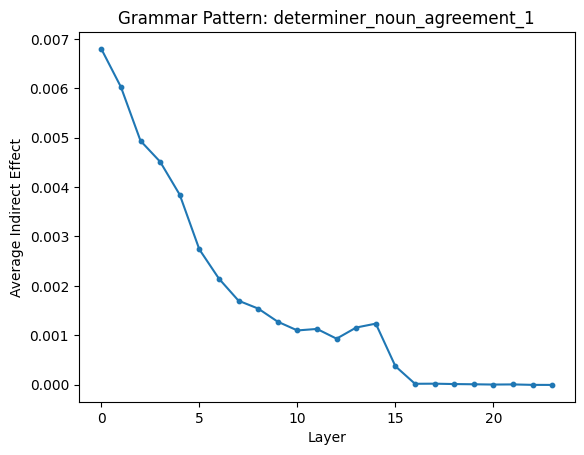

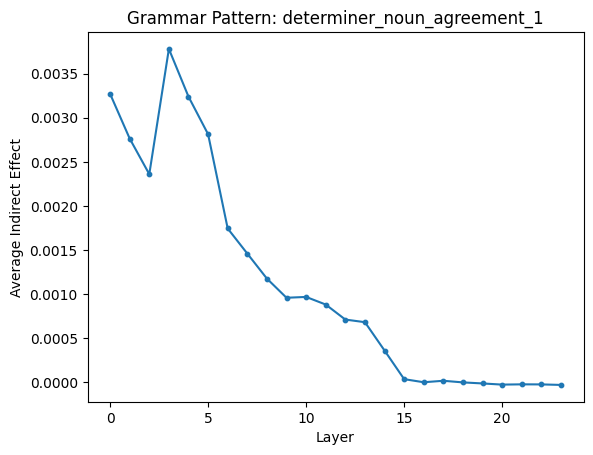

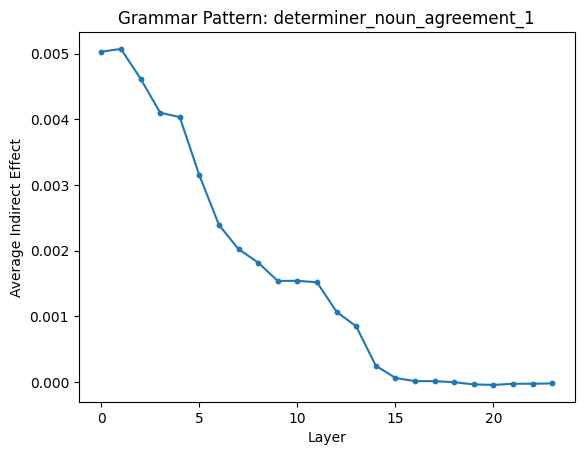

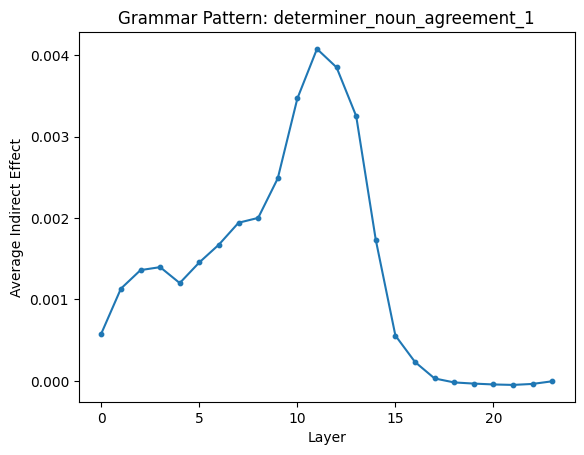

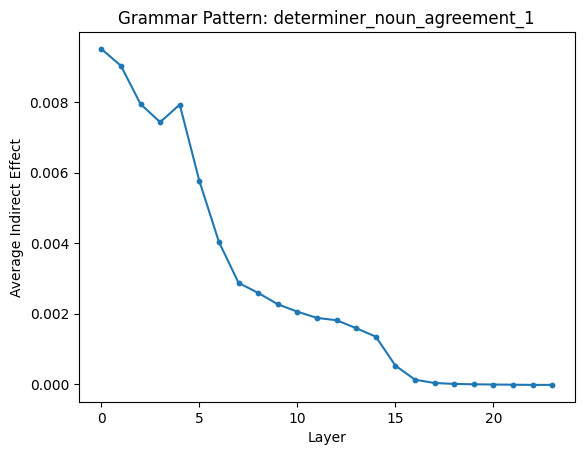

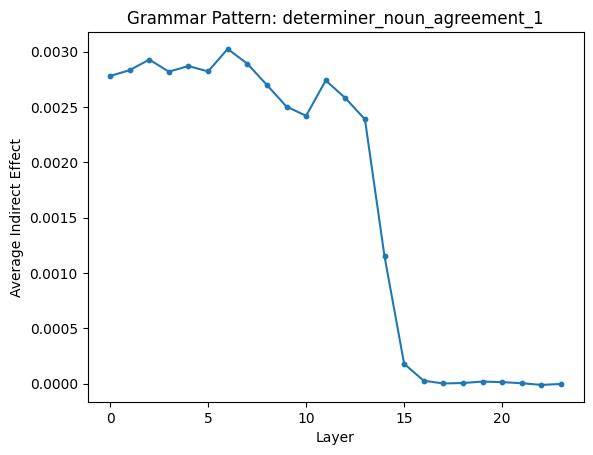

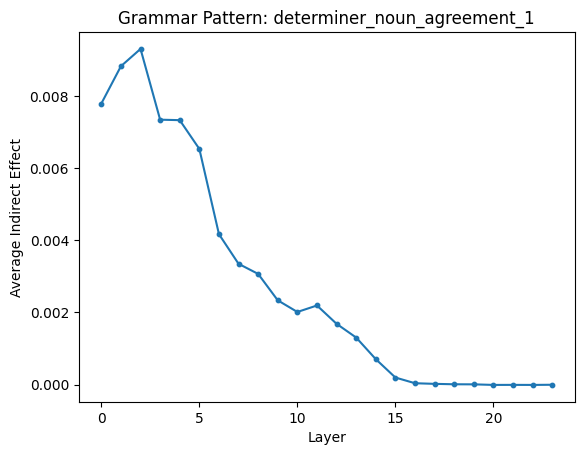

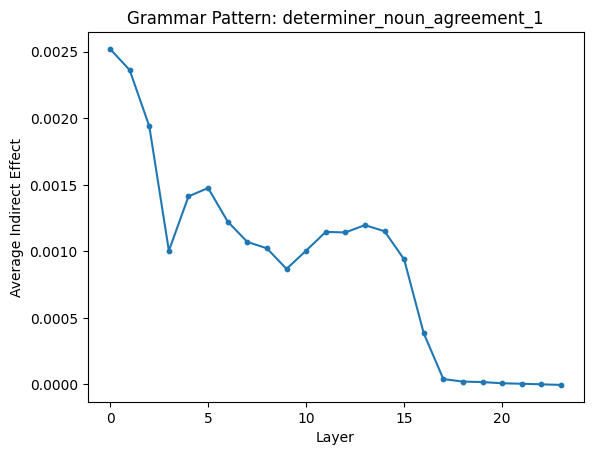

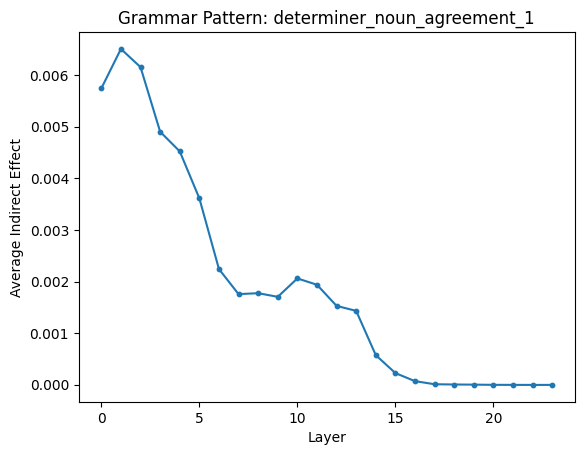

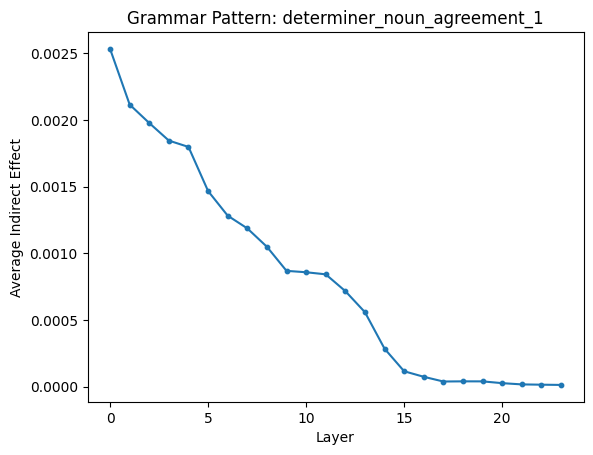

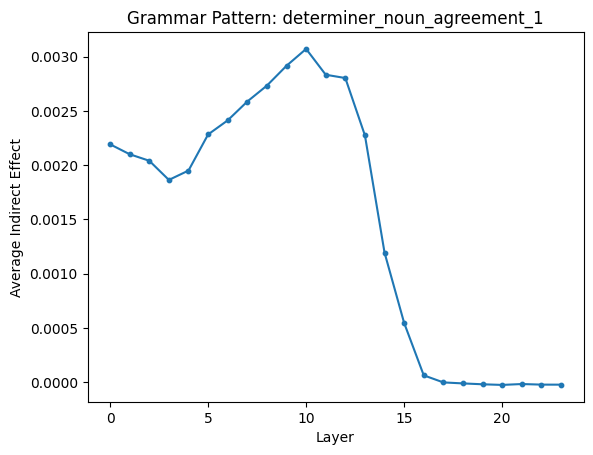

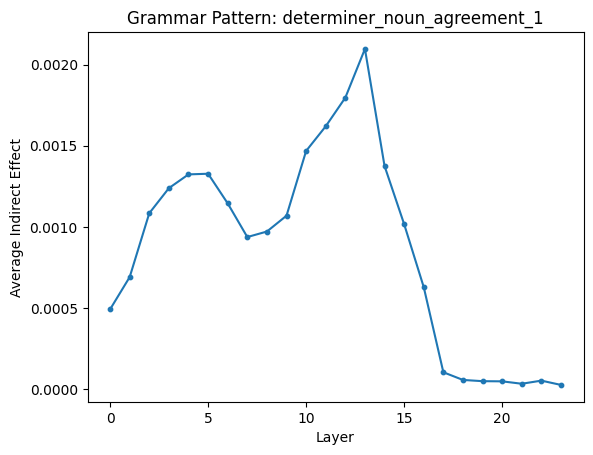

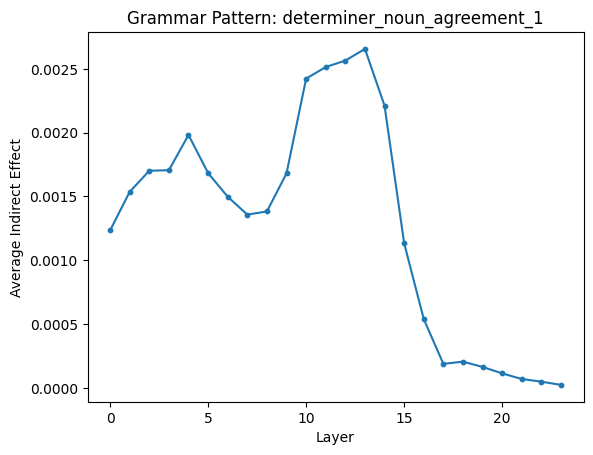

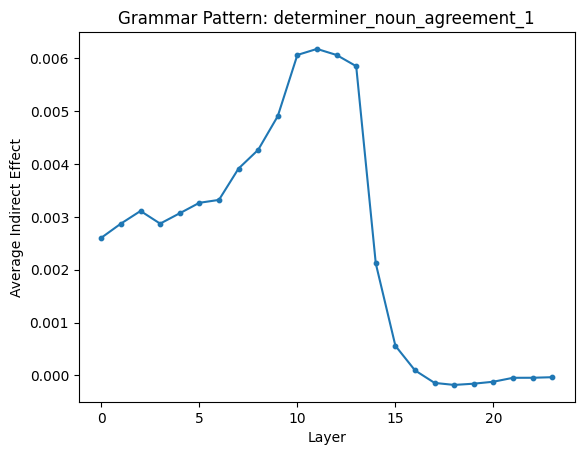

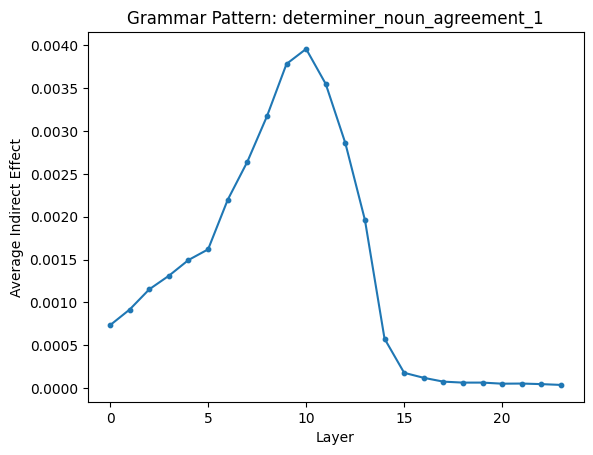

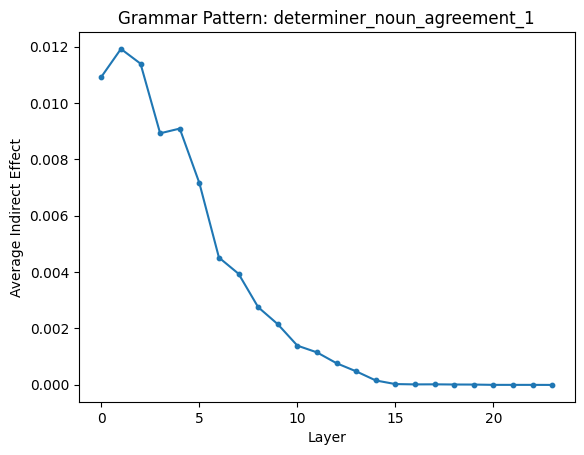

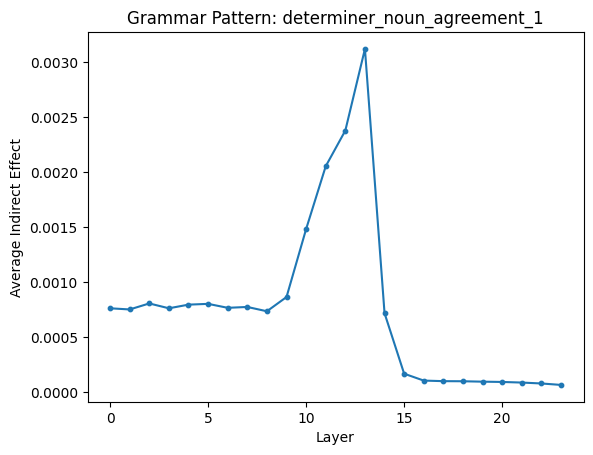

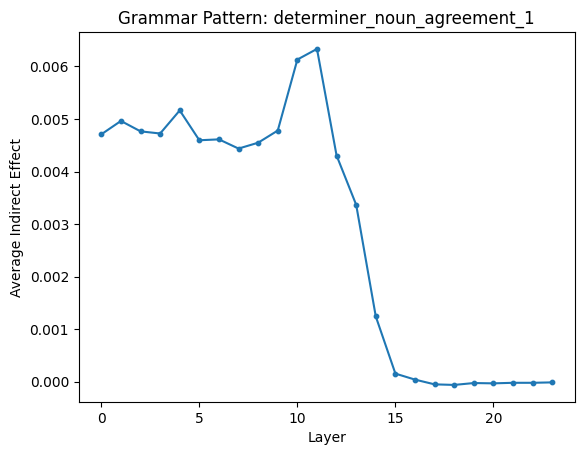

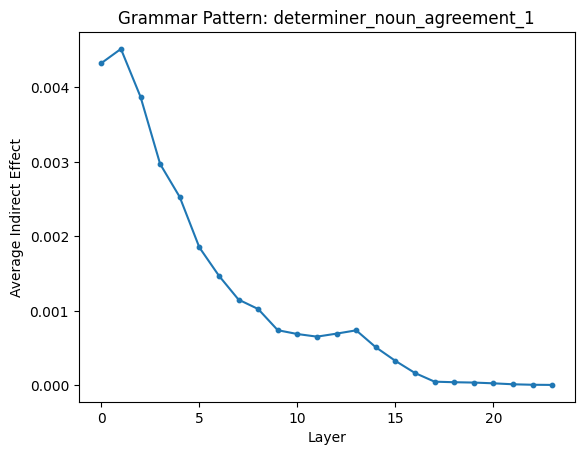

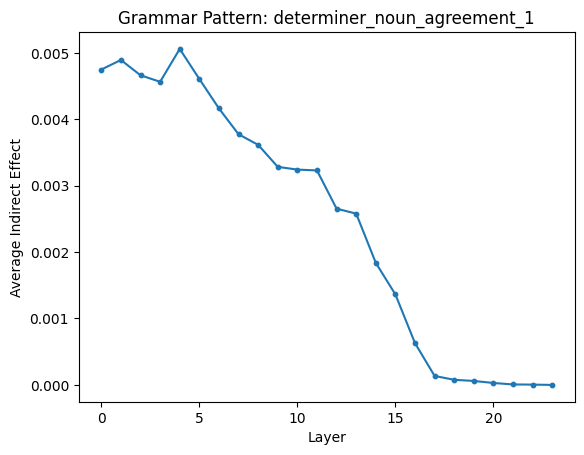

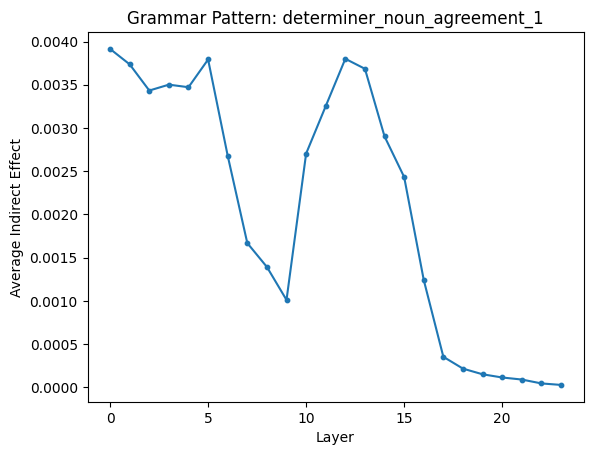

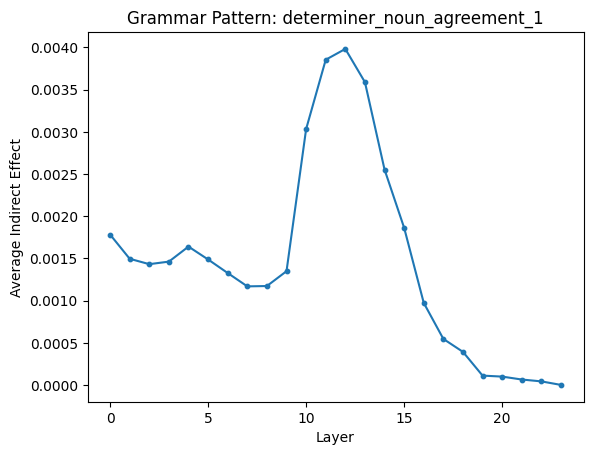

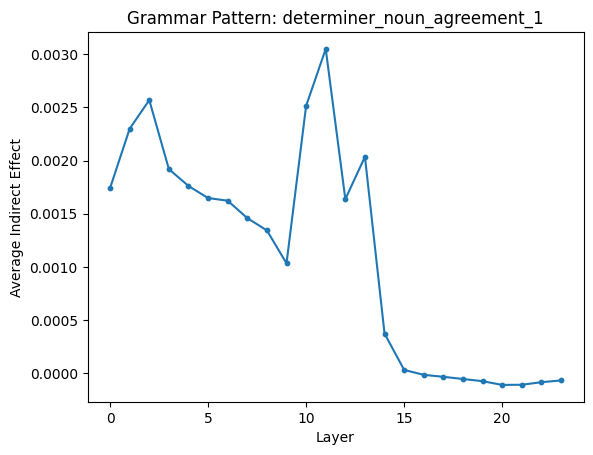

36


In [14]:
a_counter = 0

for scores in grammar_file:
    if torch.max(scores[0][0]) < 0.002:
        continue
    a_counter += 1
    plot_individual(scores, kind = "grammar")

print(a_counter)